In [3]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#all the audio samples are single-channel(mono)
audio,sampleRate=librosa.load("audioData/Animals/Bird/ffb86d3c_nohash_0.wav")
sampleRate

22050

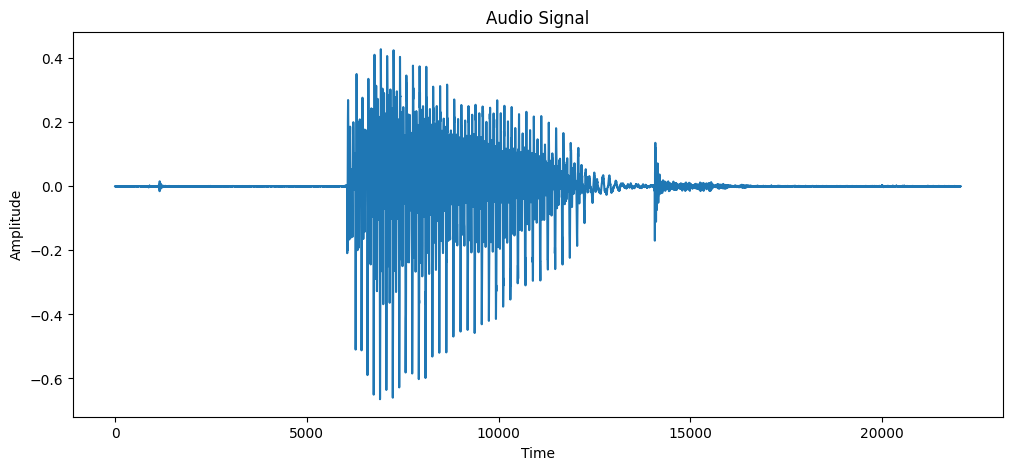

In [13]:
#Time vs Amplitude Graph of wav file
plt.figure(figsize=(12,5))
plt.plot(audio)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Audio Signal")
plt.show()

In [6]:
# To generate MFCC, we follow the following steps:
# audioInput -> pre-emphasis -> framing -> windowing -> fourier transform -> Inverse Mel Scale Filter Bank -> Log() -> DCT ->
# Derivatives -> Feature Vector

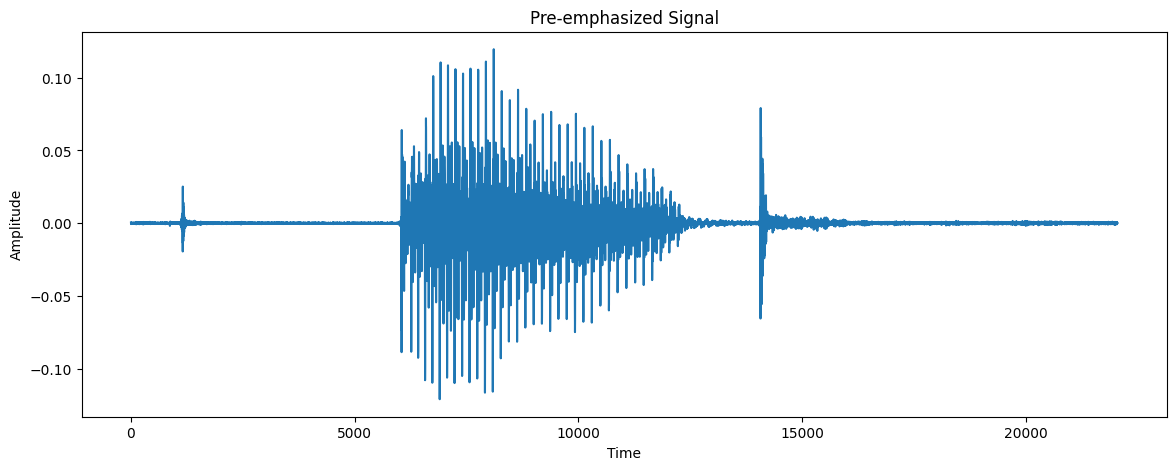

In [ ]:
# Pre-emphasis layer
# Amplifies higher frequencies in order to balance the spectrum (higher frequencies have lower energies)
pre_emphasis = 0.97
audio_preemphasized=[]
for i in range(1,sampleRate):
    audio_preemphasized.append(audio[i]-audio[i-1]*pre_emphasis)

# Plot the pre-emphasized signal
plt.figure(figsize=(14, 5))
plt.plot(audio_preemphasized)
plt.title('Pre-emphasized Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

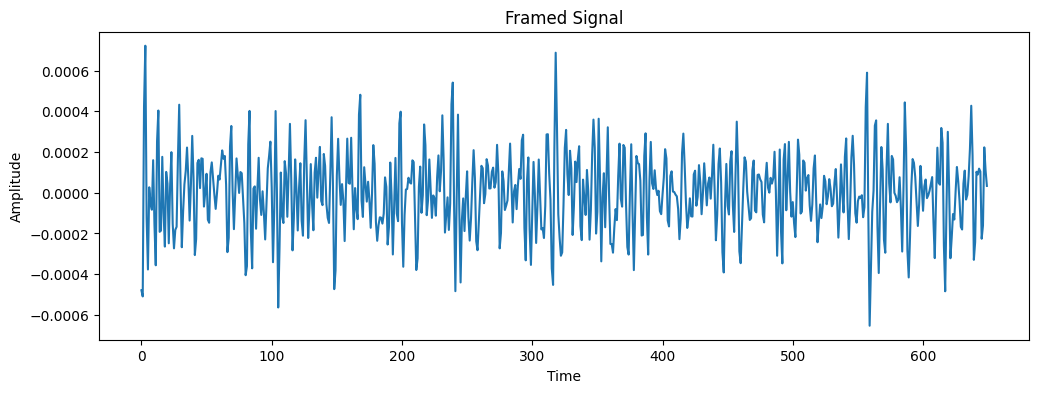

In [53]:
# Framing Layer
# Since the audio wave is more than a second, windowing is necesarry in order to fully capture the features and allow for correct
# calculations to be performed. Thus, for ease of calculations, we slice the wave.
# The signal/wave is separated into sections or frames of 25-30 milliseconds.
# Since some parts of the signal are always at the ends of the frames, and we have to perform hamming window, this may result in data loss.
# To tackle this, we frame-shift with a stride of 15ms. This ensures that parts of signals get to be in the center of the signal.

shift_stride=330  # ~15 millisecond of stride
frame_size=650 # ~30 millisecond frame
audio_frames=[]

for i in range(0,sampleRate-frame_size,shift_stride):
    audio_frames.append(audio_preemphasized[i:i+frame_size])

plt.figure(figsize=(12,4))
plt.plot(audio_frames[12])
plt.title('Framed Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# Windowing Layer




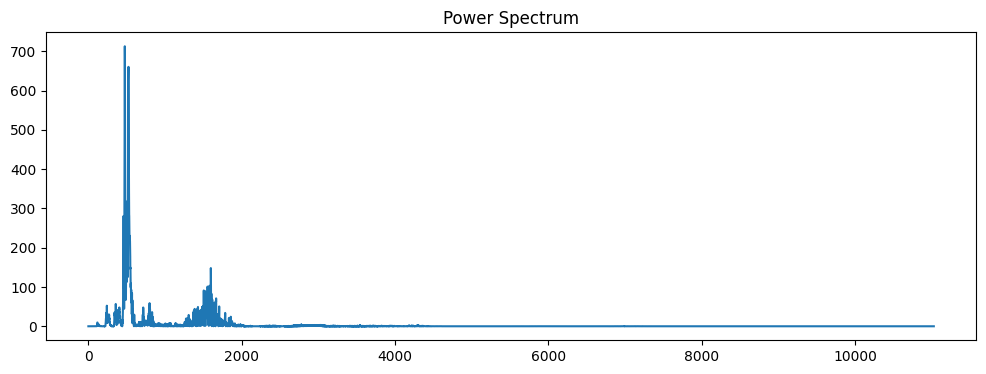

In [7]:
# FFT(Fast Fourier Transform) Layer
# Used to convert time-domain signal to frequency-domain to analyze frequency components of speech.
# Output of FFT gives complex frequency spectrum (both magnitude and phase)
# Since we only need magnitude, we evaluate the power spectrum from the output of FFT

complex_power_spectrum=np.fft.rfft(audio_preemphasized)
power_spectrum=pow(np.abs(complex_power_spectrum),2)

plt.figure(figsize=(12,4))
plt.plot(power_spectrum)
plt.title("Power Spectrum")
plt.show()